<a href="https://colab.research.google.com/github/SaulHuitzil/Analysis-of-midi-files/blob/main/Binarizar_Midi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install mido numpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 1.6 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.1
    Uninstalling packaging-24.1:
      Successfully uninstalled packaging-24.1


In [ ]:
import mido
import numpy as np
from scipy.stats import mode
import shutil
import os
import csv

from collections import Counter

from mido import MidiFile, MidiTrack, Message, MetaMessage

In [ ]:
carpeta = '/content/drive/MyDrive/Criticalidad/Música/MIDIS/'

In [ ]:
def midi_to_binary_series(file_path, time_step_method='mode'):
    """
    Convierte un archivo MIDI en una serie binaria.

    Parámetros:
        file_path (str): Ruta al archivo MIDI.
        time_step_method (str): Método para calcular el intervalo de tiempo ('mode', 'min', 'avg').
                                'mode' - Utiliza la moda del intervalo de tiempo (por defecto).
                                'min' - Utiliza el intervalo de tiempo más pequeño.
                                'avg' - Utiliza el intervalo promedio de duración de las notas.

    Retorna:
        binary_series (list): Lista de cadenas binarias que representan las notas encendidas.
    """
    # Cargar el archivo MIDI
    mid = mido.MidiFile(file_path)

    # Variables para manejo del tempo y tiempos en ticks
    current_tempo = 500000  # Tempo default (120 BPM)
    ticks_per_second = mid.ticks_per_beat / (current_tempo / 1_000_000)
    note_times = []  # Lista para almacenar tiempos de las notas en ticks
    current_ticks = 0  # Tiempo acumulado en ticks

    # Procesar los mensajes del archivo MIDI
    for track in mid.tracks:
        for msg in track:
            # Acumular tiempo en ticks
            current_ticks += msg.time

            # Actualizar el tempo si el mensaje es 'set_tempo'
            if msg.type == 'set_tempo':
                current_tempo = msg.tempo
                ticks_per_second = mid.ticks_per_beat / (current_tempo / 1_000_000)

            # Agregar tiempo si es un mensaje de nota encendida
            if msg.type == 'note_on' and msg.velocity > 0:
                note_times.append(current_ticks)

    # Calcular los intervalos de tiempo en ticks y filtrar valores menores a 10 ticks
    if len(note_times) > 1:
        intervals = [interval for interval in np.diff(sorted(note_times)) if interval >= 10]
    else:
        intervals = [mid.ticks_per_beat]  # Valor por defecto si no hay intervalos válidos

    frequencies = Counter(intervals)
    sorted_frequencies = sorted(frequencies.items(), key=lambda x: x[0], reverse=False)

    # print("Intervalos de tiempo =", intervals)  # Imprimir los intervalos calculados para diagnóstico
    print("(Intervalo_Tiempo, Frecuencia)) =", sorted_frequencies)  # Imprimir las frecuencias para diagnóstico

    # Calcular el time_step basado en el método seleccionado
    if time_step_method == 'avg' and len(intervals) > 0:
        time_step = max(np.mean(intervals), 1)  # Asegurarse de que el time_step no sea menor que 1 tick
    elif time_step_method == 'min' and len(intervals) > 0:
        time_step = max(min(intervals), 1)
    else:  # Por defecto usa 'mode'
        mode_result = mode(intervals)
        time_step = mode_result.mode[0] if isinstance(mode_result.mode, np.ndarray) else mode_result.mode

    print("Intervalo elegido =", time_step)

    # Convertir el time_step a segundos
    time_step_seconds = time_step / ticks_per_second

    # Crear la matriz para representar la serie binaria
    num_steps = int(current_ticks / max(time_step, 1))  # Evitar que time_step sea cero
    note_matrix = np.zeros((128, num_steps), dtype=int)

    # Reiniciar tiempo para asignar notas en la matriz
    current_ticks = 0
    for track in mid.tracks:
        for msg in track:
            # Acumular tiempo en ticks
            current_ticks += msg.time

            # Actualizar el tempo si el mensaje es 'set_tempo'
            if msg.type == 'set_tempo':
                current_tempo = msg.tempo
                ticks_per_second = mid.ticks_per_beat / (current_tempo / 1_000_000)

            # Agregar nota encendida a la matriz binaria
            if msg.type == 'note_on' and msg.velocity > 0:
                time_index = int(current_ticks / time_step)
                if time_index < num_steps:
                    note_matrix[msg.note, time_index] = 1

    # Convertir la matriz en una lista de cadenas binarias
    binary_series = [''.join(map(str, note_matrix[:, i])) for i in range(num_steps)]

    # Eliminar cadenas iniciales que son solo ceros
    while binary_series and all(char == '0' for char in binary_series[0]):
        binary_series.pop(0)

    return binary_series


In [ ]:
def binary_series_to_notes(binary_series):
    # Lista que contendrá las listas de notas encendidas en cada paso de tiempo
    notes_per_step = []

    # Iterar sobre cada cadena binaria de la lista binary_series
    for binary_string in binary_series:
        # Encontrar los índices (notas) donde el valor es 1
        active_notes = [i for i, char in enumerate(binary_string) if char == '1']
        notes_per_step.append(active_notes)

    return notes_per_step

In [ ]:
def notes_to_wolfram(notes_per_step, id="x01"):
  mensae = "midi" + id +  "= {"

  for tiempo in notes_per_step:
    mensae += "{"
    for nota in tiempo:
      mensae += str(nota) + ", "

    if (len(tiempo)>0):
      mensae = mensae[:-2] + "}, "
    else:
      mensae += "}, "

  mensae = mensae[:-2] + "};"
  mensae += "\nSound[{Table[SoundNote[" + id + "- 60, 0.2, \"Guitar\"], {" + id + ",  midi" + id + "}]}]"
  print(mensae)

In [ ]:
def filtrar_cadenas(binary_series):
    # Encontrar las columnas que contienen al menos un '1'
    columnas_sonadas = set()
    for cadena in binary_series:
        for idx, char in enumerate(cadena):
            if char == '1':
                columnas_sonadas.add(idx)

    # Ordenar los índices de las columnas que contienen al menos un '1'
    columnas_sonadas = sorted(columnas_sonadas)

    # Generar la lista de notas sonadas
    notas_sonadas = [idx for idx in columnas_sonadas]

    # Crear nuevas cadenas binarias con solo las notas que suenan
    cadenas_filtradas = [
        ''.join(cadena[idx] for idx in columnas_sonadas)
        for cadena in binary_series
    ]

    return notas_sonadas, cadenas_filtradas

In [ ]:
def create_midi_from_notes(note_steps, time_step=20, tempo=500000):
    """
    Crea un archivo MIDI a partir de una lista de listas de notas encendidas en cada paso de tiempo.

    Parámetros:
        note_steps (list of list of int): Lista de listas donde cada sublista contiene las notas encendidas en ese paso de tiempo.
        time_step (int): Duración en ticks de cada paso de tiempo. Por defecto 480 ticks (equivalente a una negra).
        tempo (int): Tempo del archivo MIDI en microsegundos por beat. Por defecto 500000 (120 BPM).

    Retorna:
        MidiFile: Objeto MidiFile generado con las notas especificadas.
    """
    # Crear un archivo MIDI con una pista
    mid = MidiFile(ticks_per_beat=480)
    track = MidiTrack()
    mid.tracks.append(track)

    # Establecer el tempo del archivo MIDI
    track.append(MetaMessage('set_tempo', tempo=tempo, time=0))

    # Mantener el estado de las notas activas
    active_notes = set()

    # Iterar sobre los pasos de tiempo
    for step_notes in note_steps:
        # Convertir la lista actual a un conjunto para las operaciones de diferencia
        step_notes_set = set(step_notes)

        # Determinar las notas que se deben apagar (estaban activas y ya no están en el set actual)
        notes_to_turn_off = active_notes - step_notes_set
        # Determinar las notas que se deben encender (no estaban activas y ahora están en el set actual)
        notes_to_turn_on = step_notes_set - active_notes

        # Apagar las notas que ya no están activas
        for note in notes_to_turn_off:
            track.append(Message('note_off', note=note, velocity=64, time=0))

        # Encender las nuevas notas activas
        for note in notes_to_turn_on:
            track.append(Message('note_on', note=note, velocity=64, time=0))

        # Actualizar el estado de las notas activas
        active_notes = step_notes_set

        # Avanzar el tiempo al siguiente paso
        track.append(Message('note_off', note=0, velocity=0, time=time_step))  # Time step para avanzar

    # Apagar cualquier nota restante al final
    for note in active_notes:
        track.append(Message('note_off', note=note, velocity=64, time=0))

    return mid

In [ ]:
import csv

def guardar_cadenas_binarias_como_csv(cadenas_binarias, nombre_archivo, nombres_columnas=None):
    """
    Guarda una lista de cadenas binarias en un archivo .csv,
    donde cada dígito está en una columna distinta y los encabezados
    y renglones están numerados desde cero. Permite especificar nombres
    personalizados para las columnas.

    :param cadenas_binarias: Lista de cadenas binarias (str).
    :param nombre_archivo: Nombre del archivo CSV (str).
    :param nombres_columnas: Lista opcional de nombres de columnas (int).
    """
    # Determinar la longitud de la cadena más larga para los encabezados
    max_columnas = max(len(cadena) for cadena in cadenas_binarias)

    # Crear encabezados por defecto (0, 1, 2, ...) o usar los proporcionados
    if nombres_columnas and len(nombres_columnas) == max_columnas:
        encabezados = nombres_columnas
    else:
        encabezados = list(range(max_columnas))

    # Abre el archivo en modo escritura
    with open(nombre_archivo, 'w', newline='') as archivo_csv:
        escritor = csv.writer(archivo_csv)

        # Escribe los encabezados de las columnas
        escritor.writerow([''] + encabezados)  # '' para el encabezado de los renglones

        # Itera sobre cada cadena binaria y escribe los renglones numerados
        for i, cadena in enumerate(cadenas_binarias):
            # Convierte la cadena en una lista de caracteres y la escribe como fila
            escritor.writerow([i] + list(cadena))

In [ ]:
def Analisis(archivo):
  print("Analizando:", archivo)
  file_path = carpeta + archivo + '.mid'
  new_folder = carpeta + 'analisis/' + archivo + "/"

  if not os.path.exists(carpeta + 'analisis/'): os.mkdir(carpeta + 'analisis/') # Crear carpeta si no existe
  if not os.path.exists(new_folder): os.mkdir(new_folder) # Crear carpeta si no existe

  shutil.copy(file_path, new_folder) # Copia el midi a la carpeta

  binary_series = midi_to_binary_series(file_path, time_step_method='mode')
  guardar_cadenas_binarias_como_csv(binary_series, new_folder + 'representacion_binaria_completa.csv')

  print("\n", "Cadenas binarias:", binary_series, "\n")
  # Filtrar solo notas activas en la pieza musical
  notas_sonadas, cadenas_filtradas = filtrar_cadenas(binary_series)
  print("Notas activas =", len(notas_sonadas), "\t", notas_sonadas)
  print("Lista de cadenas binarias filtradas:", cadenas_filtradas, "\n")

  guardar_cadenas_binarias_como_csv(cadenas_filtradas, new_folder + 'representacion_binaria_depurada.csv', notas_sonadas)

  # # Ejemplo de uso con tu lista binary_series
  # notes_per_step = binary_series_to_notes(binary_series)
  # print("Notas encendidas:", notes_per_step, "\n")  # Muestra las listas de notas encendidas

  # Guardar el archivo MIDI generado
  midi_file = create_midi_from_notes(binary_series_to_notes(binary_series), time_step = 100)
  midi_file.save(new_folder + 'reconstructed.mid')

  # Version Wolfram
  notes_to_wolfram(binary_series_to_notes(binary_series))

In [ ]:
# Analisis("libertango")
# Analisis("dyensFoule")
Analisis("reis-tempo-de-crianca")

Analizando: reis-tempo-de-crianca
(Intervalo_Tiempo, Frecuencia)) = [(60, 9), (120, 783), (180, 1), (240, 87), (360, 19), (480, 1)]
Intervalo elegido = 120

 Cadenas binarias: ['00000000000000000000000000000000000000000000010000000000000000001000000000000000000000000000000000000000000000000000000000000000', '00000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000', '00000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000', '00000000000000000000000000000000000000000000000000001000010010000000000000000000000000000000000000000000000000000000000000000000', '00000000000000000000000000000000000000001000000000000000000000000000000000000000000000000000000000000000000000000000000000000000', '00000000000000000000000000000000000000000000000000000000000000100000000000000000000000000000000000000000000000000000000000000000', '000000000000000000000000000000

In [ ]:
# import os
# import glob

# archivos = glob.glob(os.path.join(carpeta, '*.mid'))
# archivos = [os.path.splitext(os.path.basename(archivo))[0] for archivo in archivos]  # Obtén solo el nombre sin extensión
# # archivos = [os.path.basename(archivo) for archivo in archivos]  # Obtén solo el nombre y extensión
# archivos.sort()


# for archivo in archivos:
#   Analisis(archivo)

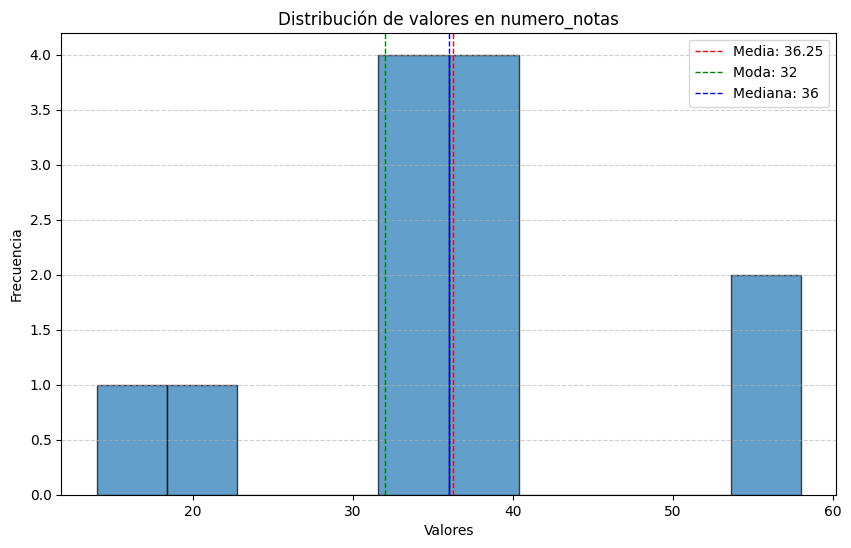

In [ ]:
import matplotlib.pyplot as plt

# Lista de números
numero_notas = [36, 39, 32, 40, 39, 32, 14, 58, 21, 32, 58, 34]

# Crear un histograma para visualizar la distribución de los datos
plt.figure(figsize=(10, 6))
plt.hist(numero_notas, bins=10, edgecolor='black', alpha=0.7)
plt.title('Distribución de valores en numero_notas')
plt.xlabel('Valores')
plt.ylabel('Frecuencia')

# Mostrar la media, mediana y moda para determinar el valor más representativo
media = sum(numero_notas) / len(numero_notas)
moda = max(set(numero_notas), key=numero_notas.count)
mediana = sorted(numero_notas)[len(numero_notas) // 2]

# Añadir líneas y texto indicativo para la media, mediana y moda
plt.axvline(media, color='red', linestyle='dashed', linewidth=1, label=f'Media: {media:.2f}')
plt.axvline(moda, color='green', linestyle='dashed', linewidth=1, label=f'Moda: {moda}')
plt.axvline(mediana, color='blue', linestyle='dashed', linewidth=1, label=f'Mediana: {mediana}')

plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

#numero_notas = [36, 39, 32, 40, 39, 32, 14, 58, 21, 32, 58, 34]

In [ ]:
# mid = mido.MidiFile(file_path)

# print(mid)

In [ ]:
# def parse_note_string(note_string):
#     """
#     Convierte una cadena de texto con notación de conjuntos a una lista de listas de notas.

#     Parámetros:
#         note_string (str): Cadena de texto con la notación de conjuntos,
#                            por ejemplo: "{{54, 60}, {57}, {54, 57, 72}, ...}".

#     Retorna:
#         list of list of int: Lista de listas de notas.
#     """
#     # Reemplazar los dobles corchetes y llaves por simples
#     formatted_string = note_string.replace('{{', '[').replace('}}', ']').replace('{', '[').replace('}', ']')

#     # Convertir la cadena formateada a una lista de listas usando eval de forma segura
#     try:
#         note_list = eval(formatted_string, {"__builtins__": None}, {})
#     except Exception as e:
#         print(f"Error al evaluar la cadena: {e}")
#         return []

#     return note_list

In [ ]:
# import mido
# import numpy as np

# def midi_to_binary_series(file_path, time_step_method='min'):
#     """
#     Convierte un archivo MIDI en una serie binaria.

#     Parámetros:
#         file_path (str): Ruta al archivo MIDI.
#         time_step_method (str): Método para calcular el intervalo de tiempo ('min' o 'avg').
#                                 'min' - Utiliza el intervalo de tiempo más pequeño (por defecto).
#                                 'avg' - Utiliza el intervalo promedio de duración de las notas.

#     Retorna:
#         binary_series (list): Lista de cadenas binarias que representan las notas encendidas.
#     """
#     # Cargar el archivo MIDI
#     mid = mido.MidiFile(file_path)

#     # Obtener todos los tiempos de las notas en ticks
#     note_times = []
#     for track in mid.tracks:
#         current_time = 0
#         for msg in track:
#             current_time += msg.time
#             if msg.type == 'note_on' and msg.velocity > 0:
#                 note_times.append(current_time)

#     # Calcular los intervalos de tiempo en ticks y filtrar los valores menores a 10
#     if len(note_times) > 1:
#         intervals = [interval for interval in np.diff(sorted(note_times)) if interval >= 10]
#     else:
#         intervals = [mid.ticks_per_beat]  # Si no hay intervalos válidos, usar un valor por defecto

#     # Calcular el time_step basado en el método seleccionado
#     if time_step_method == 'avg' and len(intervals) > 0:
#         time_step = max(np.mean(intervals), 1)  # Asegurarse de que el time_step no sea menor que 1
#     else:
#         time_step = max(min(intervals), 1) if len(intervals) > 0 else 1  # Valor mínimo de 1 para evitar problemas

#     print("time_step =", time_step)

#     # Convertir el tiempo de ticks a segundos usando el tempo del archivo MIDI
#     tempo = 500000  # Establece un tempo default (120 BPM) si no se especifica en el archivo
#     for track in mid.tracks:
#         for msg in track:
#             if msg.type == 'set_tempo':
#                 tempo = msg.tempo

#     ticks_per_second = mid.ticks_per_beat / (tempo / 1_000_000)
#     time_step_seconds = time_step / ticks_per_second  # Conversión correcta de time_step a segundos

#     # Crear la matriz para representar la serie binaria
#     total_time = sum(msg.time for track in mid.tracks for msg in track if not msg.is_meta)
#     num_steps = int(total_time / max(time_step, 1))  # Evitar que time_step sea cero
#     note_matrix = np.zeros((128, num_steps), dtype=int)

#     current_time = 0
#     for track in mid.tracks:
#         for msg in track:
#             current_time += msg.time
#             if msg.type == 'note_on' and msg.velocity > 0:
#                 time_index = int(current_time / time_step)
#                 if time_index < num_steps:
#                     note_matrix[msg.note, time_index] = 1

#     # Convertir la matriz en una lista de cadenas binarias
#     binary_series = [''.join(map(str, note_matrix[:, i])) for i in range(num_steps)]
#     return binary_series

# # Ejemplo de uso
# file_path = '/content/drive/MyDrive/Criticalidad/Música/libertango.mid'
# binary_series = midi_to_binary_series(file_path, time_step_method='min')  # Usa 'min' o 'avg'
# print(binary_series[:10])


In [ ]:
# import mido
# import numpy as np
# from scipy.stats import mode

# def midi_to_binary_series(file_path, time_step_method='mode'):
#     """
#     Convierte un archivo MIDI en una serie binaria.

#     Parámetros:
#         file_path (str): Ruta al archivo MIDI.
#         time_step_method (str): Método para calcular el intervalo de tiempo ('mode', 'min', 'avg').
#                                 'mode' - Utiliza la moda del intervalo de tiempo (por defecto).
#                                 'min' - Utiliza el intervalo de tiempo más pequeño.
#                                 'avg' - Utiliza el intervalo promedio de duración de las notas.

#     Retorna:
#         binary_series (list): Lista de cadenas binarias que representan las notas encendidas.
#     """
#     # Cargar el archivo MIDI
#     mid = mido.MidiFile(file_path)

#     # Variables para manejo del tempo y tiempos en ticks
#     current_tempo = 500000  # Tempo default (120 BPM)
#     ticks_per_second = mid.ticks_per_beat / (current_tempo / 1_000_000)
#     note_times = []  # Lista para almacenar tiempos de las notas en ticks
#     current_ticks = 0  # Tiempo acumulado en ticks

#     # Procesar los mensajes del archivo MIDI
#     for track in mid.tracks:
#         for msg in track:
#             # Acumular tiempo en ticks
#             current_ticks += msg.time

#             # Actualizar el tempo si el mensaje es 'set_tempo'
#             if msg.type == 'set_tempo':
#                 current_tempo = msg.tempo
#                 ticks_per_second = mid.ticks_per_beat / (current_tempo / 1_000_000)

#             # Agregar tiempo si es un mensaje de nota encendida
#             if msg.type == 'note_on' and msg.velocity > 0:
#                 note_times.append(current_ticks)

#     # Calcular los intervalos de tiempo en ticks y filtrar valores menores a 10 ticks
#     if len(note_times) > 1:
#         intervals = [interval for interval in np.diff(sorted(note_times)) if interval >= 10]
#     else:
#         intervals = [mid.ticks_per_beat]  # Valor por defecto si no hay intervalos válidos

#     print(intervals)  # Imprimir los intervalos calculados para diagnóstico

#     # Calcular el time_step basado en el método seleccionado
#     if time_step_method == 'avg' and len(intervals) > 0:
#         time_step = max(np.mean(intervals), 1)  # Asegurarse de que el time_step no sea menor que 1 tick
#     elif time_step_method == 'min' and len(intervals) > 0:
#         time_step = max(min(intervals), 1)
#     else:  # Por defecto usa 'mode'
#         mode_result = mode(intervals)
#         time_step = mode_result.mode[0] if isinstance(mode_result.mode, np.ndarray) else mode_result.mode

#     # Convertir el time_step a segundos
#     time_step_seconds = time_step / ticks_per_second

#     # Crear la matriz para representar la serie binaria
#     num_steps = int(current_ticks / max(time_step, 1))  # Evitar que time_step sea cero
#     note_matrix = np.zeros((128, num_steps), dtype=int)

#     # Reiniciar tiempo para asignar notas en la matriz
#     current_ticks = 0
#     for track in mid.tracks:
#         for msg in track:
#             # Acumular tiempo en ticks
#             current_ticks += msg.time

#             # Actualizar el tempo si el mensaje es 'set_tempo'
#             if msg.type == 'set_tempo':
#                 current_tempo = msg.tempo
#                 ticks_per_second = mid.ticks_per_beat / (current_tempo / 1_000_000)

#             # Agregar nota encendida a la matriz binaria
#             if msg.type == 'note_on' and msg.velocity > 0:
#                 time_index = int(current_ticks / time_step)
#                 if time_index < num_steps:
#                     note_matrix[msg.note, time_index] = 1

#     # Convertir la matriz en una lista de cadenas binarias
#     binary_series = [''.join(map(str, note_matrix[:, i])) for i in range(num_steps)]
#     return binary_series

# # Ejemplo de uso
# file_path = '/content/drive/MyDrive/Criticalidad/Música/dyensFoule.mid'
# binary_series = midi_to_binary_series(file_path, time_step_method='mode')
# print(binary_series)
